Random Forest Accuracy: 0.8122448979591836
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       200
           1       0.33      0.02      0.04        45

    accuracy                           0.81       245
   macro avg       0.58      0.51      0.47       245
weighted avg       0.73      0.81      0.74       245



PermutationExplainer explainer: 246it [00:18,  6.22it/s]                         


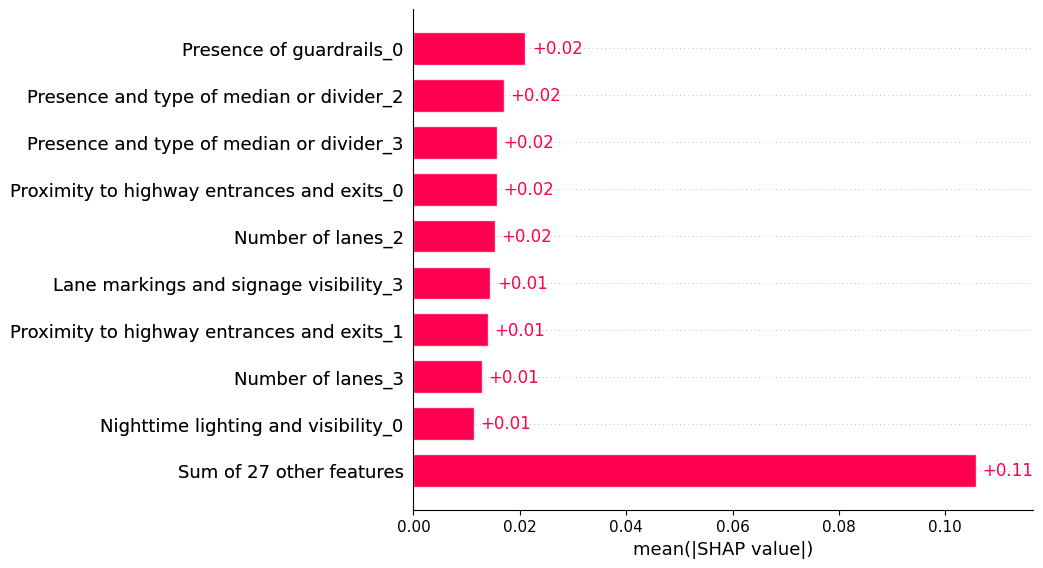

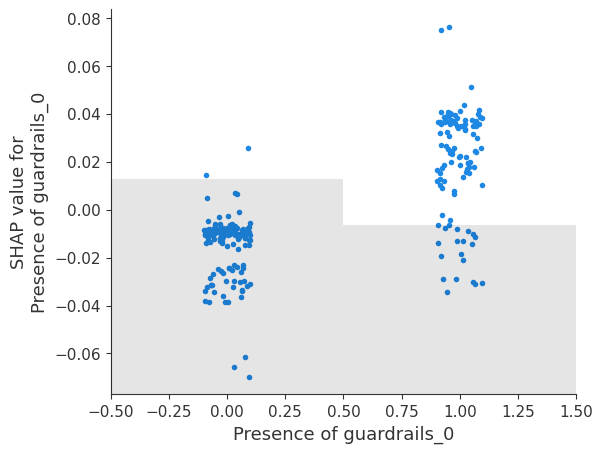

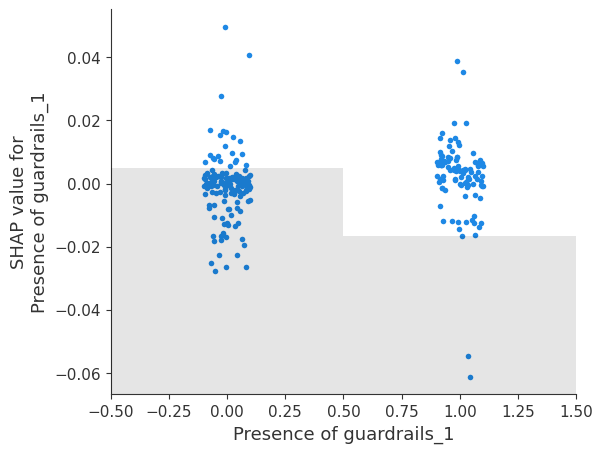

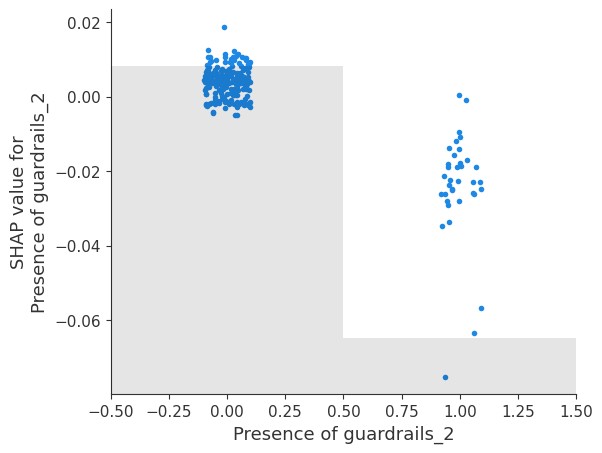

In [29]:
# 1. Load and preprocess the data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("../datasets/ALL_I40_crash_data_final.csv")

# Combine all crash types not equal to 'Property Damage' as 'Injury'
df['Crash Type'] = df['Crash Type'].apply(lambda x: 'Property Damage' if x == 'Property Damage' else 'Injury')


# Select relevant features
features = [
    'Presence of guardrails', 'Cable barriers', 'Rumble strips', 'Pavement condition',
    'Proximity to highway entrances and exits', 'Urban vs. rural environment',
    'Surrounding natural features', 'Number of lanes', 'Shoulder type and width',
    'Posted speed limit', 'Presence and type of median or divider',
    'Lane markings and signage visibility', 'Nighttime lighting and visibility'
]

# Clean and preprocess
df_clean = df[features + ['Crash Type']]
df_clean = df_clean.replace('none', pd.NA).dropna()
X = pd.get_dummies(df_clean[features])
y = df_clean['Crash Type'].map({'Property Damage': 0, 'Injury': 1})

# One-hot encode full dataset first to avoid column mismatches
X_full = pd.get_dummies(df_clean[features])
y_full = df_clean['Crash Type'].map({'Property Damage': 0, 'Injury': 1})

# Ensure consistent feature columns during train-test split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)



# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


# 5. SHAP analysis with TreeExplainer (Random Forest only)
explainer = shap.Explainer(rf.predict_proba, X_train)
shap_values = explainer(X_test)


# Force plot for a specific observation
sample_idx = 0


# 6. Feature importance summary
shap.plots.bar(shap_values[..., 1])

# 7. SHAP dependence plot for a specific feature (e.g., Presence of guardrails)
# Replace with the actual feature name after one-hot encoding
# Loop over guardrail features
for col in X_test.columns:
    if 'Presence of guardrails' in col:
        shap.plots.scatter(shap_values[:, col, 1])  # class 1 = Injury


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/jm/d1z4xqgd3qvddnq0y3kf3lvw0000gq/T/ipykernel_8680/3853598543.py:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[...,1], X_test_sample, plot_type="bar")


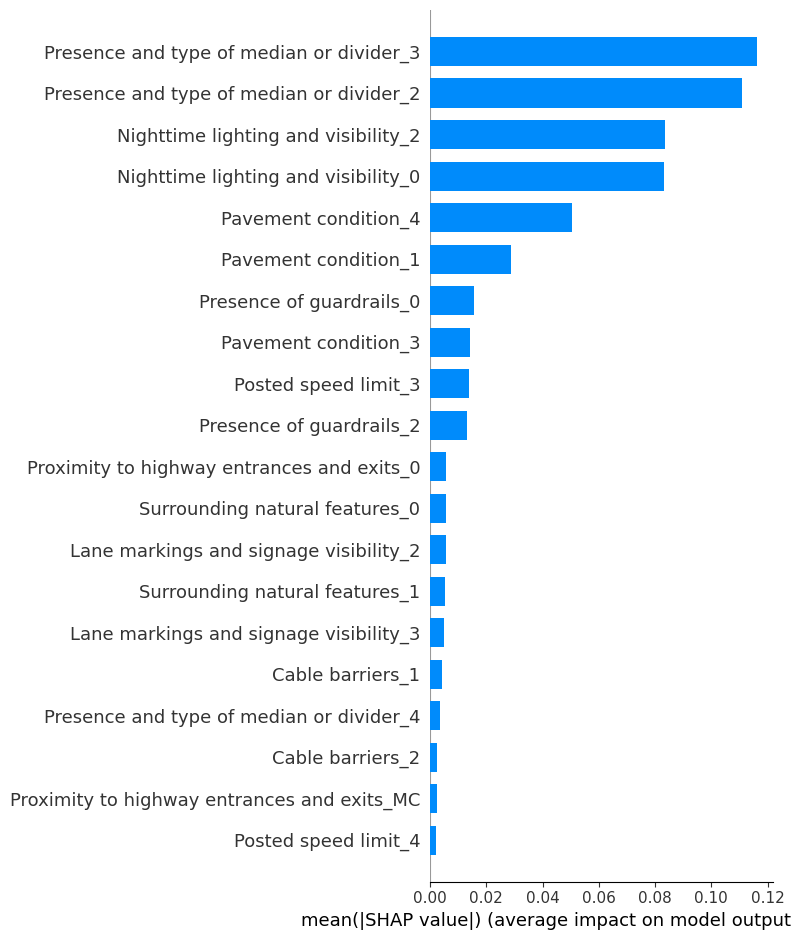

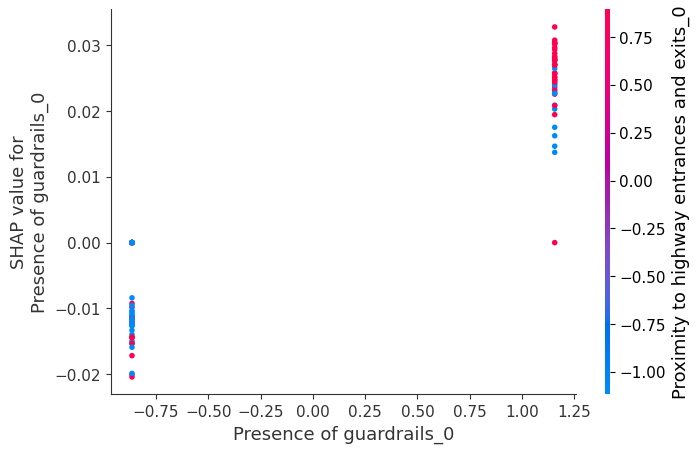

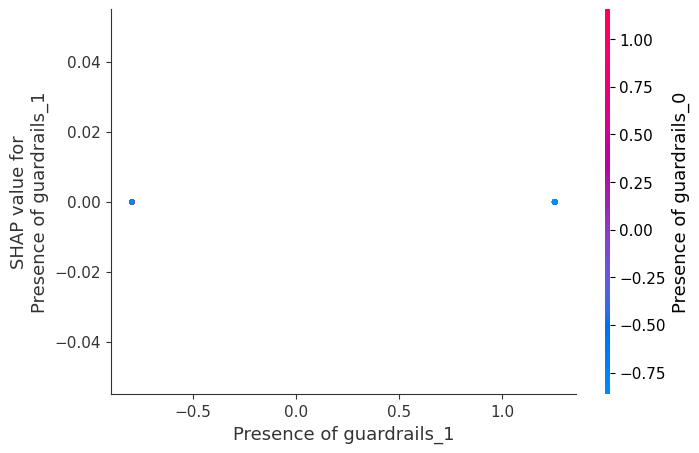

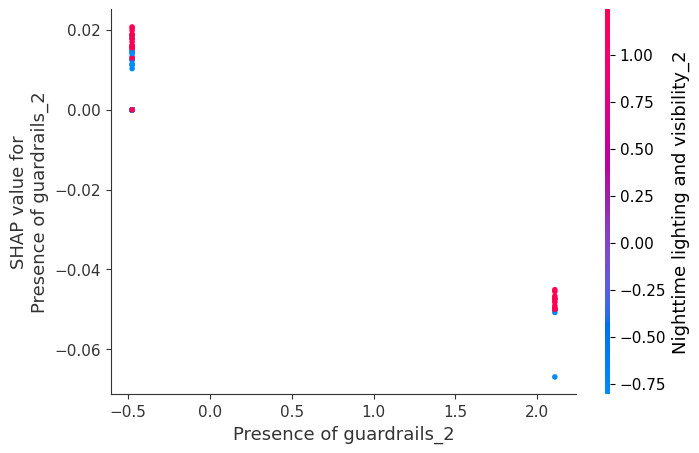

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# 1. Load and preprocess data
df = pd.read_csv("../datasets/ALL_I40_crash_data_final.csv")
df['Crash Type'] = df['Crash Type'].apply(lambda x: 'Property Damage' if x == 'Property Damage' else 'Injury')

features = [
    'Presence of guardrails', 'Cable barriers', 'Rumble strips', 'Pavement condition',
    'Proximity to highway entrances and exits', 'Urban vs. rural environment',
    'Surrounding natural features', 'Number of lanes', 'Shoulder type and width',
    'Posted speed limit', 'Presence and type of median or divider',
    'Lane markings and signage visibility', 'Nighttime lighting and visibility'
]

df_clean = df[features + ['Crash Type']].replace('none', pd.NA).dropna()
X = pd.get_dummies(df_clean[features])
y = df_clean['Crash Type'].map({'Property Damage': 0, 'Injury': 1})

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# 5. SHAP with KernelExplainer (only use 100 samples for speed)
explainer = shap.KernelExplainer(logreg.predict_proba, X_train_scaled[:100])
shap_values = explainer.shap_values(X_test_scaled[:100])

# 6. Reconstruct readable feature names
X_test_sample = pd.DataFrame(X_test_scaled[:100], columns=X.columns)

# 7. Summary plot for class 1 = Injury
shap.summary_plot(shap_values[...,1], X_test_sample, plot_type="bar")

# 8. Dependence plots for "Presence of guardrails"
guardrail_features = [col for col in X.columns if "Presence of guardrails" in col]
for col in guardrail_features:
    shap.dependence_plot(col, shap_values[...,1], X_test_sample)
